<a href="https://colab.research.google.com/github/yeshivadataanalytics/predict-alzheimers/blob/zeyu/3_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
!pip install -U tensorflow-addons

In [21]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
from os import listdir
from os.path import isfile, join

In [22]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 540
num_epochs = 100
image_size = 80  # We'll resize input images to this size
patch_size = 10  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

In [23]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [24]:
train_AD = [f for f in listdir('/content/gdrive/MyDrive/capstone/image_transformer/train/AD/') if isfile(join('/content/gdrive/MyDrive/capstone/image_transformer/train/AD/', f))]
train_MCI = [f for f in listdir('/content/gdrive/MyDrive/capstone/image_transformer/train/MCI/') if isfile(join('/content/gdrive/MyDrive/capstone/image_transformer/train/MCI/', f))]
test_AD = [f for f in listdir('/content/gdrive/MyDrive/capstone/image_transformer/val/AD/') if isfile(join('/content/gdrive/MyDrive/capstone/image_transformer/val/AD/', f))]
test_MCI = [f for f in listdir('/content/gdrive/MyDrive/capstone/image_transformer/val/MCI/') if isfile(join('/content/gdrive/MyDrive/capstone/image_transformer/val/MCI/', f))]

In [25]:
from PIL import Image
import numpy as np

In [26]:
num_classes = 2
input_shape = (200, 200, 4)

In [27]:
x_train = []
y_train = []

In [28]:
for i in train_AD:
    imag1 = np.asarray(Image.open('/content/gdrive/MyDrive/capstone/image_transformer/'+'/train/AD/'+i))
    x_train.append(imag1)
    y_train.append(1)

In [29]:
for i in train_MCI:
    imag1 = np.asarray(Image.open('/content/gdrive/MyDrive/capstone/image_transformer/'+'/train/MCI/'+i))
    x_train.append(imag1)
    y_train.append(0)

In [30]:
x_train = np.array(x_train)
y_train = np.array(y_train)

In [31]:
x_test = []
y_test = []

In [32]:
for i in test_AD:
    imag1 = np.asarray(Image.open('/content/gdrive/MyDrive/capstone/image_transformer/'+'/val/AD/'+i))
    x_test.append(imag1)
    y_test.append(1)

In [33]:
for i in test_MCI:
    imag1 = np.asarray(Image.open('/content/gdrive/MyDrive/capstone/image_transformer/'+'/val/MCI/'+i))
    x_test.append(imag1)
    y_test.append(0)

In [34]:
x_test = np.array(x_test)
y_test = np.array(y_test)

In [35]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

In [36]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [37]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: 80 X 80
Patch size: 10 X 10
Patches per image: 64
Elements per patch: 400


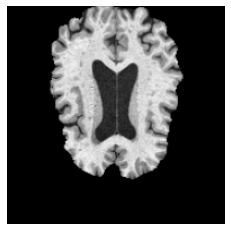

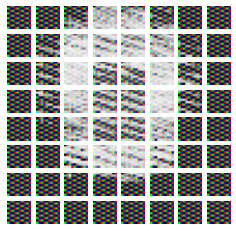

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch[0:300], (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [39]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [40]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [41]:
model = create_vit_classifier()
optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )
model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

In [42]:
checkpoint_filepath = "/content/gdrive/MyDrive/capstone/tmp/checkpoint"
checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

In [73]:
history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=200,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

Epoch 1/200
1/1 [==============================] - 15s 15s/step - loss: 0.1412 - accuracy: 0.9474 - top-5-accuracy: 1.0000 - val_loss: 1.6400 - val_accuracy: 0.5636 - val_top-5-accuracy: 1.0000
Epoch 2/200
1/1 [==============================] - 13s 13s/step - loss: 0.1811 - accuracy: 0.9271 - top-5-accuracy: 1.0000 - val_loss: 1.5196 - val_accuracy: 0.5818 - val_top-5-accuracy: 1.0000
Epoch 3/200
1/1 [==============================] - 13s 13s/step - loss: 0.1332 - accuracy: 0.9413 - top-5-accuracy: 1.0000 - val_loss: 1.4735 - val_accuracy: 0.6000 - val_top-5-accuracy: 1.0000
Epoch 4/200
1/1 [==============================] - 13s 13s/step - loss: 0.1216 - accuracy: 0.9413 - top-5-accuracy: 1.0000 - val_loss: 1.4904 - val_accuracy: 0.5636 - val_top-5-accuracy: 1.0000
Epoch 5/200
1/1 [==============================] - 13s 13s/step - loss: 0.1419 - accuracy: 0.9332 - top-5-accuracy: 1.0000 - val_loss: 1.5187 - val_accuracy: 0.5636 - val_top-5-accuracy: 1.0000
Epoch 6/200
1/1 [=============

In [75]:

_, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
print(f"Test accuracy: {round(accuracy * 100, 2)}%")
print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

9/9 [==============================] - 3s 290ms/step - loss: 1.3193 - accuracy: 0.7196 - top-5-accuracy: 1.0000
Test accuracy: 71.96%
Test top 5 accuracy: 100.0%
